Code based on https://github.com/blei-lab/variational-smc.

In [12]:
using Random, LinearAlgebra, Distributions, ForwardDiff, Plots

In [2]:
mutable struct LGSS_SMC
    T::Integer     # Length of sequence
    dimX::Integer # Dimension of latent variables
    dimY::Integer # Dimension of observations
    N::Integer     # Number of particles
    
    sim_prop # Function for sampling from proposal
    log_weights # Function for computing weights
end

In [45]:
# TODO: fix seed

function resampling(W; seed=Random.seed!(0))
    # TODO: this isn't the resampling algorithm described in the paper?
    # Taking indices, adding uniform noise, then dividing by N, and re-fitting them into bins
    N = size(W)[1]
    bins = cumsum(W,dims=1)#cumsum(W[:,1])
    ind = 0:N-1
    u = (ind + rand(N)) / N
    digitize = i -> searchsortedfirst(bins[:,1],i)
    return digitize.(u)
    #cat = Categorical(W[:,1])
    #return rand(cat,N)
end

function vsmc_lower_bound(prop_params, model_params, y, smc_obj; seed=Random.seed(0), verbose=false, adapt_resamp=false)
    # Extract constants
    T = size(y)[1]
    dimX = smc_obj.dimX
    N = smc_obj.N
    
    # Initialize SMC
    X = zeros(N,dimX)
    Xp = zeros(N,dimX)
    logW = zeros(N)
    W = exp.(logW) ./ N
    logZ = 0
    ESS = (1/sum(W.^2)) / N # Effective sample size
    
    for t in 1:T
        # Resampling
        if adapt_resamp
            # TODO
        else
            if t > 1
                ancestors = resampling(W,seed=seed)
                Xp = X[ancestors,:]
            else
                Xp = X
            end
        end
        
        # Propagation
        X = smc_obj.sim_prop(t, Xp, y, prop_params, model_params, seed=seed)
        
        # Reweighting
        if adapt_resamp
            # TODO
        else
            #logW = vec(smc_obj.log_weights(t, X, Xp, y, prop_params, model_params))
            logW = smc_obj.log_weights(t, X, Xp, y, prop_params, model_params)
        end
        max_logW = max(logW...)
        W = exp.(logW .- max_logW)
        if adapt_resamp
            # TODO
        else
            logZ = logZ + max_logW + log(sum(W)) - log(N)
        end
        W /= sum(W)
        ESS = (1/sum(W.^2)) / N
    end
    if verbose
        println("ESS: ", ESS)
    end
    return logZ
end

vsmc_lower_bound (generic function with 1 method)

In [40]:
function init_model_params(dimX, dimY, α, r, obs; seed=Random.seed(0))
    μ0 = 0
    Σ0 = 1
    
    A = 0.5
    #for i in 1:dimX
    #    for j in 1:dimX
    #        A[i,j] = α^(abs(i-j)+1)
    #    end
    #end
    
    Q = 1
    
    # TODO: obs
    # C = zeros(dimY,dimX)
    C = 1
    
    R = 1
    
    return μ0, Σ0, A, Q, C, R
end

function init_prop_params(T, dimX, scale; seed=Random.seed(0))
    return scale*randn(dimX)[1]
end

function generate_data(model_params, T; seed=Random.seed(0))
    μ0, Σ0, A, Q, C, R = model_params
    
    x_true = zeros(T)
    y_true = zeros(T)
    
    for t in 1:T
        if t > 1
            x_dist = Normal(A*x_true[t-1],Q)
            x_true[t] = rand(x_dist,1)[1]
        else
            # x_dist = Normal(μ0,Σ0)
            x_true[t] = 0
        end
        
        y_dist = Normal(C*x_true[t],R)
        y_true[t] = rand(y_dist,1)[1]
    end
    
    return x_true, y_true
end

function log_marginal_likelihood(model_params, T, y_true)
    μ0, Σ0, A, Q, C, R = model_params
    
    # Compute via Kalman filter
    log_likelihood = 0
    
    x_filt = 0
    P_filt = 0
    x_pred = μ0
    P_pred = Σ0
    
    for t in 1:T
        if t > 1
            # Predict
            x_pred = A * x_filt
            P_pred = A*P_filt*A' + Q
        end
        
        # Update
        yt = y_true[t] - C*x_pred
        S = C*P_pred*C' + R
        K = (S \ (C*P_pred))'
        x_filt = x_pred + K*yt
        P_filt = P_pred - K*C*P_pred
        
        # TODO: double check this correct
        log_likelihood += -0.5*(dot(yt,S\yt) + logdet(S) + dimY*log(2*π))
    end
    return log_likelihood
end

function sim_prop(t, Xp, y, prop_params, model_params; seed=Random.seed!(0))
    μ0, Σ0, A, Q, C, R = model_params
    λ = prop_params
    
    N, dimX = size(Xp)
    
    if t > 0
        # TODO: why based on target and not variational model?
        # μ = (A*Xp')'
        μ = λ .+ 0.5.*Xp
    else
        μ = reshape(repeat(λ + 0.5*μ0,inner=N),N,dimX)
    end
    return μ + randn(N,dimX)
end

function log_normal(x,μ,Σ)
    dim = 1
    log_norm = -0.5*dim*log(2*π) - 0.5*logdet(Σ)
    prec = inv(Σ)
    if size(x) == size(μ)
        diff = x - μ
    else
        diff = x .- μ'
    end
    return log_norm .- 0.5*sum(diff*prec*diff',dims=2)
end

function log_target(t, Xc, Xp, y, prop_params, model_params)
    μ0, Σ0, A, Q, C, R = model_params
    if t > 1
        logF = log_normal(Xc,(A*Xp')',Q)
    else
        logF = log_normal(Xc,μ0,Σ0)
    end
    logG = log_normal((C*Xc')',y[t],R)
    return logF + logG
end

function log_prop(t,Xc,Xp,y,prop_params,model_params)
    μ0, Σ0, A, Q, C, R = model_params
    λ = prop_params
    if t > 1
        μ = λ .+ 0.5*Xp # (A*Xp')'
    else
        μ = λ + 0.5*μ0
    end
    return log_normal(Xc,μ,1)#Matrix{Float64}(I,dimX,dimX) .* σ2t)
end

function log_weights(t, Xc, Xp, y, prop_params, model_params)
    return log_target(t,Xc,Xp,y,prop_params,model_params) - log_prop(t,Xc,Xp,y,prop_params,model_params)
end

log_weights (generic function with 1 method)

True log-marginal likelihood: -2.6031598969259164
((0, 1, 0.5, 1, 1, 1), 0.1486439922677308)
VSMC lower bound: -1.6380404760941418


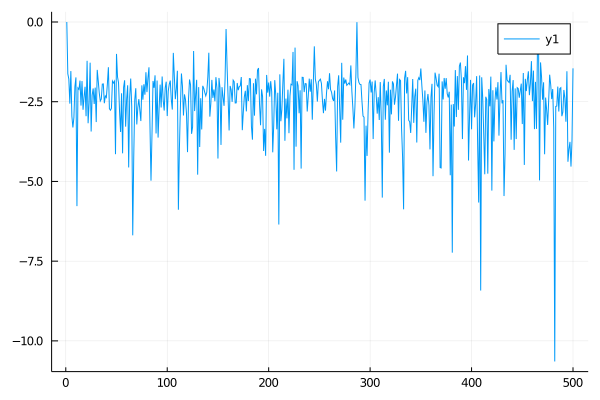

In [47]:
# Model hyperparameters
T = 2
dimX = 1
dimY = 1
α = 0.5 #0.42
r = 1 #0.1
obs = "sparse"

# Training parameters
param_scale = 0.5
num_epochs = 1000
step_size = 0.001

N = 4

data_seed = Random.seed!(1)
model_params = init_model_params(dimX, dimY, α, r, obs, seed=data_seed)

x_true, y_true = generate_data(model_params, T, seed=data_seed)

log_marginal = log_marginal_likelihood(model_params, T, y_true)
println("True log-marginal likelihood: ", log_marginal)

seed = Random.seed!(1)

prop_params = init_prop_params(T, dimX, param_scale, seed=seed)
combined_init_params = (model_params, prop_params)
println(combined_init_params)

lgss_smc_obj = LGSS_SMC(T,dimX,dimY,N,sim_prop,log_weights)

println("VSMC lower bound: ",vsmc_lower_bound(prop_params, model_params, y_true, lgss_smc_obj, seed=seed))

function objective(λ)
    return vsmc_lower_bound(λ, model_params, y_true, lgss_smc_obj, seed=seed)
end

function adam(iter,∇L,ss;δ=1e-16,t=0.1,η=0.1)
    s = t*(∇L)^2+(1-t)*ss
    ρ = η*iter^(-1/2+δ)*(1+sqrt(s))^(-1)
    return s,ρ
end

iters = 500
λs = zeros(iters)
λs[1] = prop_params
vsmcb = zeros(iters)
ss = ones(iters)
ρs = zeros(iters)
for i in 1:iters-1
    ∇λ = ForwardDiff.gradient(λ->objective(λ[1]),[λs[i]])[1]
    s,ρ = adam(i,∇λ,ss[i])
    ss[i+1] = s
    ρs[i+1] = ρ
    λs[i+1] = λs[i] + ρ*∇λ
    vsmcb[i+1] = vsmc_lower_bound(λs[i+1],model_params,y_true,lgss_smc_obj,seed=seed)
end
plot(1:iters,vsmcb)

#function objective(combined_params)
#    model_params, prop_params = combined_params
#    return -vsmc_lower_bound(prop_params, model_params, y_true, lgss_smc_obj, seed=seed)
#end

#@zerograd cumsum(W::Array{Float64,1},dims::Integer)

#p = Param(combined_params)
#∇o = @diff objective(p)

#function objective(μ0, Σ0, A, Q, C, R, prop_params, t, prop_params_t)
#    model_params = (μ0, Σ0, A, Q, C, R)
#    if t > 0
#        prop_params[t] = prop_params_t
#    end
#    return -vsmc_lower_bound(prop_params, model_params, y_true, lgss_smc_obj, seed=seed)
#end

#μ0, Σ0, A, Q, C, R = model_params
#ForwardDiff.gradient((t,pt...)->objective(μ0, Σ0, A, Q, C, R, prop_params, t,(pt[1:3],pt[4:6],pt[7:10])),(1,(prop_params[1])...))



1.3472314486736117


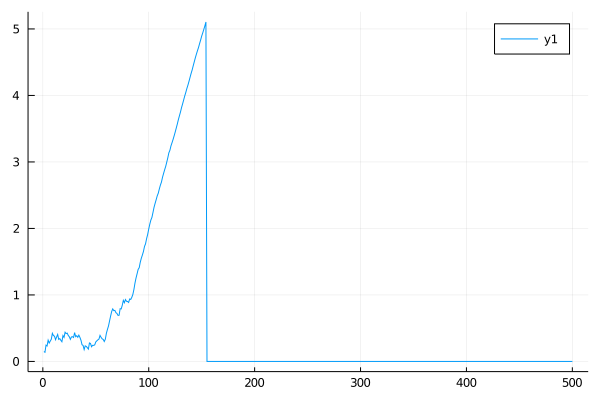

In [44]:
println(var(λs))
plot(1:iters,λs)

In [6]:
prop_params[1]...

LoadError: [91msyntax: "..." expression outside call around In[6]:1[39m

In [7]:
function adam(iter,∇L,ss;δ=1e-16,t=0.1,η=1)
    s = t*(∇L)^2+(1-t)*ss
    ρ = η*n^(-1/2+δ)*(1+sqrt(s))^(-1)
    return s,ρ
end

iter = 100
ss = zeros(iter)
combined_params = combined_init_params
for i in 1:iter-1
    
    ∇L = ForwardDiff.gradient(p->objective(p),combined_params)
    s,ρ = adam(i,∇L,s[i])
    ss[i+1] = s
    combined_params = combined_params .+ ρ*∇L
end

LoadError: [91mMethodError: no method matching gradient(::var"#12#13", ::Tuple{Tuple{Int64,Int64,Float64,Int64,Int64,Int64},Float64})[39m
[91m[0mClosest candidates are:[39m
[91m[0m  gradient(::Any, [91m::StaticArrays.StaticArray[39m) at C:\Users\chiuk\.julia\packages\ForwardDiff\m7cm5\src\gradient.jl:44[39m
[91m[0m  gradient(::Any, [91m::StaticArrays.StaticArray[39m, [91m::ForwardDiff.GradientConfig[39m) at C:\Users\chiuk\.julia\packages\ForwardDiff\m7cm5\src\gradient.jl:45[39m
[91m[0m  gradient(::Any, [91m::StaticArrays.StaticArray[39m, [91m::ForwardDiff.GradientConfig[39m, [91m::Val[39m) at C:\Users\chiuk\.julia\packages\ForwardDiff\m7cm5\src\gradient.jl:46[39m
[91m[0m  ...[39m

In [8]:
function prodsum(A,b,x)
    return sum(A*x) + b
end

temp = (a,b) -> prodsum(reshape(a,2,2),b,[2,-1])
K = Matrix{Float64}(I,2,2)
k = vec(K)
n=4
println([1.0 0 0 1 -2][1:4])
∇t = ForwardDiff.gradient(a->temp(a[1:n],a[n+1]),[1.0 0 0 1 -2])
println(∇t)
println(reshape(∇t[1:4],2,2))
println(reshape(k+∇t[1:4],2,2))
j = [1.0 0 0 1 -2]+∇t
temp(j[1:4],j[5])
prodsum(K,-2,[2,-1])
#println(prodsum(Matrix{Float64}(I,2,2)+∇t[1],-2+∇t[2],[1,-1]))

[1.0, 0.0, 0.0, 1.0]
[2.0 2.0 -1.0 -1.0 1.0]
[2.0 -1.0; 2.0 -1.0]
[3.0 -1.0; 2.0 0.0]


-1.0

In [9]:
[(K...)]

4-element Array{Float64,1}:
 1.0
 0.0
 0.0
 1.0